<a href="https://colab.research.google.com/github/jmcaussade/Tarea1-Analitica-textual-con-ML/blob/main/Copia_de_Lab_01_Analitica_Textual_con_ML_Laboratorio_pre_procesamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 1 Alanítica textual con Machine Learning"
##Preprocesamiento de texto
### Integrantes:
#### - Jean Michel Caussade
#### - Sebastián Bobenrieth


## Instalación de librerias

In [2]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.5 MB/s eta 0:00:00


Importar librerias necesarias


In [3]:
import os
import pandas as pd
import numpy as np
import re
# NLTK (Natural Language ToolKit) es una libreria para NLP
import nltk
# Existe extensiones que debemos descargar

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from collections import defaultdict
from collections import Counter
from unidecode import unidecode
from tqdm.notebook import tqdm
from itertools import chain

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Lectura base de datos en Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ruta_data_set = '/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea1/COAH_dataset.xlsx'
df = pd.read_excel(ruta_data_set)

Descripción de las variables a estudiar
1. **Id:** Identificador del comentario
2. **Rank:** Nota otorgada por el usuario (del 1 al 5, con 5 mayor satisfacción)
3. **Abstract:** Título del comentario (ingresado por el usuario)
4. **Review:** Cuerpo del comentario (ingresado por el usuario)


In [6]:
df.describe(include='all')

id         rank   abstract  \
count   1816.000000  1816.000000       1816   
unique          NaN          NaN       1681   
top             NaN          NaN  Excelente   
freq            NaN          NaN         15   
mean     908.500000     3.400881        NaN   
std      524.378362     1.440875        NaN   
min        1.000000     1.000000        NaN   
25%      454.750000     2.000000        NaN   
50%      908.500000     4.000000        NaN   
75%     1362.250000     5.000000        NaN   
max     1816.000000     5.000000        NaN   

                                                   review  
count                                                1816  
unique                                               1792  
top     La peor experiencia que he tenido en un hotel....  
freq                                                    2  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

# Análisis Exploratorio de Datos: Variable Objetivo

Para analizar el comportamiento de los datos de la variable objetivo (rating), generamos un gráfico de barras.

rank
5    531
4    489
1    312
3    285
2    199
Name: count, dtype: int64


<Axes: xlabel='rank'>

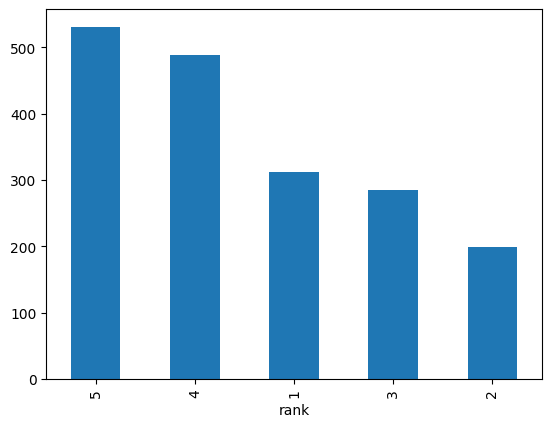

In [7]:
print(df['rank'].value_counts())
df['rank'].value_counts().plot(kind='bar')

In [8]:
print(df['rank'].unique())


[5 4 3 2 1]


Utilizaremos la definición clásica en análisis de sentimientos **recodificando** el rating en los siguientes valores:

1 y 2 -> 0 (Negativo)

3 -> 1 (Neutro)

4 y 5 -> 2 (Positivo)



rank
2    1020
0     511
1     285
Name: count, dtype: int64


<Axes: xlabel='rank'>

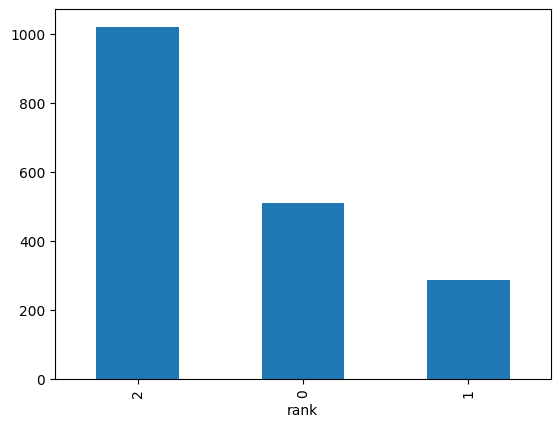

In [9]:
df['rank'] = df['rank'].replace({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})

# Imprimir y graficar la distribucion de los ratings simplificados
print(df['rank'].value_counts())
df['rank'].value_counts().plot(kind='bar')

# Procesamiento de texto

Los pasos son:

1. **Limpieza**, la remoción del contenido no deseado.
2. **Normalización**, la conversión diferentes formas a una sola.
3. **Tokenización**, la separación del texto en tókenes (unidades mínimas, por ejemplo palabras).
4. Separación en **conjuntos de datos**: entrenamiento, validación, prueba.
5. Generación del **vocabulario**, la lista de tókenes conocidos.
6. **Numericalización**, el mapeo de tókenes a números enteros.

Estos pasos son comunes distintas aproximaciones al procesamiento del lenguaje.

## Limpieza

In [10]:
def limpiar(texto):
    puntuación = r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']'

    # signos de puntuación
    texto = re.sub(puntuación, ' ', texto)

    # dígitos [0-9]
    texto = re.sub('\d', ' ', texto)

    return texto

## Normalización


In [11]:
def normalizar(texto):
    # todo a minúsculas
    texto = texto.lower()

    # tildes y diacríticas
    texto = re.sub('á', 'a', texto)
    texto = re.sub('é', 'e', texto)
    texto = re.sub('í', 'i', texto)
    texto = re.sub('ó', 'o', texto)
    texto = re.sub('ú', 'u', texto)
    texto = re.sub('ü', 'u', texto)
    texto = re.sub('ñ', 'n', texto)

    return texto

## Unicode


In [12]:
def repazo_unicode(texto):
    texto = unidecode(texto)
    return texto

## Quizás corregir ortografía???

## Tokenización


In [13]:
def texto_tokenizer(texto):
    tokens = word_tokenize(texto)
    return tokens

## Lemmatizacion





In [14]:
nltk.download("wordnet")
nltk.download("omw-1.4")
wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
def texto_lematization(texto_tokenizado, wnl):
    lemmatized_tokens = []
    for token in texto_tokenizado:
        # Check if the token is alphabetic
        if token.isalpha():
            # Lemmatize the token and add to the list
            lemmatized_token = wnl.lemmatize(token)
            lemmatized_tokens.append(lemmatized_token)
        else:
            # If it's not a word (e.g., punctuation), add it unchanged
            lemmatized_tokens.append(token)

    return lemmatized_tokens


## Test pre-procesamiento actual

In [16]:
df

id  rank                                          abstract  \
0        1     2                        Un hotel digno de mención!   
1        2     2  Recomendable 100%, sin lujos pero todo perfecto.   
2        3     1                                         Decepción   
3        4     2                      Por segunda vez, inmejorable   
4        5     2                                   No tan sorpresa   
...    ...   ...                                               ...   
1811  1812     2           remanso de paz en el corazón de Córdoba   
1812  1813     2             Oasis de paz, tranquilidad y belleza!   
1813  1814     2                            Un lugar para recordar   
1814  1815     2                                    Extraordinario   
1815  1816     2  Ojalá hubiese hoteles así en todas las ciudades.   

                                                 review  
0     Como bien les comenté a los propietarios a la ...  
1     Estuvimos dos días con mi familia, reservando ...  
2     Habíamos escogido este hotel por las buenas op...  
3     Hemos vuelto por segunda vez a este estupendo ...  
4     He estado dos días en Granada por trabajo, soy...  
...                                                 ...  
1811  Hemos empezado el año con una estancia de tres...  
1812  Al atravesar el umbral de la puerta que conduc...  
1813  En este hotel todo son sensaciones y experienc...  
1814  Hemos pasado un par de noches en este exquisit...  
1815  El hotel es precioso, esta muy bien ubicado pa...  

[1816 rows x 4 columns]

In [17]:
def preprocesar1(texto):
    texto = limpiar(texto)
    texto = normalizar(texto)
    texto = repazo_unicode(texto)
    texto = texto_tokenizer(texto)
    texto = texto_lematization(texto, wnl)
    return texto

In [19]:
for index, row in df.iterrows():
    review_text = row['review']

    processed_review = preprocesar1(review_text)
    print(f"processed_review: {processed_review}")

    df.at[index, 'processed_review'] = processed_review

processed_review: ['como', 'bien', 'le', 'comente', 'a', 'los', 'propietarios', 'a', 'la', 'hora', 'de', 'abandonar', 'el', 'hotel', 'no', 'dudare', 'un', 'momento', 'en', 'recomendar', 'una', 'y', 'otra', 'vez', 'el', 'hotel', 'albero', 'de', 'granada', 'su', 'situacion', 'respecto', 'del', 'centro', 'de', 'granada', 'no', 'e', 'la', 'mejor', 'pero', 'para', 'nuestros', 'propositos', 'era', 'perfecto', 'escapada', 'de', 'fin', 'de', 'semana', 'con', 'visita', 'a', 'la', 'alhambra', 'se', 'encuentra', 'en', 'la', 'carretera', 'de', 'paso', 'a', 'sierra', 'nevada', 'y', 'muy', 'cercano', 'a', 'la', 'alhambra', 'por', 'la', 'zona', 'se', 'puede', 'encontrar', 'aparcamiento', 'y', 'este', 'se', 'encuentra', 'en', 'una', 'zona', 'segura', 'y', 'tranquila', 'los', 'parking', 'del', 'centro', 'de', 'granada', 'que', 'no', 'recomendaron', 'en', 'el', 'hotel', 'fueron', 'lo', 'que', 'no', 'dijeron', 'nada', 'caros', 'y', 'pudimos', 'movernos', 'por', 'el', 'centro', 'perfectamente', 'desde', '

In [20]:
df

id  rank                                          abstract  \
0        1     2                        Un hotel digno de mención!   
1        2     2  Recomendable 100%, sin lujos pero todo perfecto.   
2        3     1                                         Decepción   
3        4     2                      Por segunda vez, inmejorable   
4        5     2                                   No tan sorpresa   
...    ...   ...                                               ...   
1811  1812     2           remanso de paz en el corazón de Córdoba   
1812  1813     2             Oasis de paz, tranquilidad y belleza!   
1813  1814     2                            Un lugar para recordar   
1814  1815     2                                    Extraordinario   
1815  1816     2  Ojalá hubiese hoteles así en todas las ciudades.   

                                                 review  \
0     Como bien les comenté a los propietarios a la ...   
1     Estuvimos dos días con mi familia, reservando ...   
2     Habíamos escogido este hotel por las buenas op...   
3     Hemos vuelto por segunda vez a este estupendo ...   
4     He estado dos días en Granada por trabajo, soy...   
...                                                 ...   
1811  Hemos empezado el año con una estancia de tres...   
1812  Al atravesar el umbral de la puerta que conduc...   
1813  En este hotel todo son sensaciones y experienc...   
1814  Hemos pasado un par de noches en este exquisit...   
1815  El hotel es precioso, esta muy bien ubicado pa...   

                                       processed_review  
0     [como, bien, le, comente, a, los, propietarios...  
1     [estuvimos, do, dia, con, mi, familia, reserva...  
2     [habiamos, escogido, este, hotel, por, la, bue...  
3     [hemos, vuelto, por, segunda, vez, a, este, es...  
4     [he, estado, do, dia, en, granada, por, trabaj...  
...                                                 ...  
1811  [hemos, empezado, el, ano, con, una, estancia,...  
1812  [al, atravesar, el, umbral, de, la, puerta, qu...  
1813  [en, este, hotel, todo, son, sensaciones, y, e...  
1814  [hemos, pasado, un, par, de, noches, en, este,...  
1815  [el, hotel, e, precioso, esta, muy, bien, ubic...  

[1816 rows x 5 columns]

### Stop Words

In [21]:
def rem_stopwords(tokens):
    global tag_map
    texto_final = []
    for token, tag in pos_tag(tokens):
        if token not in stopwords.words('spanish'):
            texto_final.append(token)
    # return ' '.join(texto_final)
    return texto_final


spanish_stopwords = set(stopwords.words('spanish'))
rem_stopwords2 = lambda tokens: [token for token, tag in pos_tag(tokens) if token not in spanish_stopwords]

In [22]:
tqdm.pandas()

# Pre-procesamiento del Dataframe entero son approx. 15 min
#df['comentario_tokenizado'] = df['comentario_tokenizado'].progress_apply(rem_stopwords) lentooooo!!!!
df['con_stop_words'] = df['processed_review'].progress_apply(rem_stopwords2)

  0%|          | 0/1816 [00:00<?, ?it/s]

In [23]:
df

id  rank                                          abstract  \
0        1     2                        Un hotel digno de mención!   
1        2     2  Recomendable 100%, sin lujos pero todo perfecto.   
2        3     1                                         Decepción   
3        4     2                      Por segunda vez, inmejorable   
4        5     2                                   No tan sorpresa   
...    ...   ...                                               ...   
1811  1812     2           remanso de paz en el corazón de Córdoba   
1812  1813     2             Oasis de paz, tranquilidad y belleza!   
1813  1814     2                            Un lugar para recordar   
1814  1815     2                                    Extraordinario   
1815  1816     2  Ojalá hubiese hoteles así en todas las ciudades.   

                                                 review  \
0     Como bien les comenté a los propietarios a la ...   
1     Estuvimos dos días con mi familia, reservando ...   
2     Habíamos escogido este hotel por las buenas op...   
3     Hemos vuelto por segunda vez a este estupendo ...   
4     He estado dos días en Granada por trabajo, soy...   
...                                                 ...   
1811  Hemos empezado el año con una estancia de tres...   
1812  Al atravesar el umbral de la puerta que conduc...   
1813  En este hotel todo son sensaciones y experienc...   
1814  Hemos pasado un par de noches en este exquisit...   
1815  El hotel es precioso, esta muy bien ubicado pa...   

                                       processed_review  \
0     [como, bien, le, comente, a, los, propietarios...   
1     [estuvimos, do, dia, con, mi, familia, reserva...   
2     [habiamos, escogido, este, hotel, por, la, bue...   
3     [hemos, vuelto, por, segunda, vez, a, este, es...   
4     [he, estado, do, dia, en, granada, por, trabaj...   
...                                                 ...   
1811  [hemos, empezado, el, ano, con, una, estancia,...   
1812  [al, atravesar, el, umbral, de, la, puerta, qu...   
1813  [en, este, hotel, todo, son, sensaciones, y, e...   
1814  [hemos, pasado, un, par, de, noches, en, este,...   
1815  [el, hotel, e, precioso, esta, muy, bien, ubic...   

                                         con_stop_words  
0     [bien, comente, propietarios, hora, abandonar,...  
1     [do, dia, familia, reservando, do, habitacione...  
2     [habiamos, escogido, hotel, buenas, opiniones,...  
3     [vuelto, segunda, vez, estupendo, hotel, grana...  
4     [do, dia, granada, trabajo, autonomo, busco, a...  
...                                                 ...  
1811  [empezado, ano, estancia, tres, noches, hotel,...  
1812  [atravesar, umbral, puerta, conduce, zaguan, h...  
1813  [hotel, sensaciones, experiencias, positivas, ...  
1814  [pasado, par, noches, exquisito, hotel, regent...  
1815  [hotel, precioso, bien, ubicado, recorrer, cor...  

[1816 rows x 6 columns]

## Vocabulario

#### Elementos más comunes


In [30]:
def counter(token_list):
  count = Counter(token_list)
  return count

#### Chaining lists of lists

In [31]:
def to_single_list(list_of_lists):
    return list(chain.from_iterable(list_of_lists))

In [32]:
toke_list = to_single_list(df['con_stop_words'])

In [33]:
print(counter(toke_list))

Counter({'hotel': 2885, 'habitacion': 1224, 'si': 1100, 'ma': 1075, 'bien': 1041, 'dia': 917, 'habitaciones': 901, 'personal': 773, 'desayuno': 585, 'solo': 493, 'piscina': 472, 'habia': 469, 'bano': 466, 'precio': 437, 'recepcion': 431, 'noche': 423, 'zona': 413, 'buena': 412, 'do': 407, 'bastante': 398, 'comida': 395, 'calidad': 384, 'aunque': 365, 'tambien': 343, 'centro': 338, 'mejor': 330, 'servicio': 314, 'limpieza': 313, 'bueno': 297, 'ir': 291, 'toda': 288, 'trato': 287, 'playa': 284, 'semana': 276, 'mal': 274, 'fin': 272, 'tenia': 269, 'ubicacion': 266, 'asi': 264, 'estrellas': 261, 'vista': 257, 'ademas': 256, 'puede': 253, 'buen': 249, 'ser': 249, 'ciudad': 245, 'verdad': 242, 'vez': 241, 'cama': 238, 'ano': 231, 'parking': 228, 'estancia': 228, 'menos': 227, 'persona': 225, 'cerca': 224, 'coche': 222, 'minutos': 221, 'alli': 217, 'siempre': 217, 'decir': 217, 'recomiendo': 216, 'estan': 215, 'amable': 213, 'mismo': 212, 'restaurante': 204, 'gente': 204, 'situado': 204, 'lug

#### Class Vocabulario

In [56]:
class Vocab():
    def __init__(self, tóken_desconocido='<unk>'):
        self.tóken_desconocido = tóken_desconocido
        self.mapeo = {}
        self.frecuencia = None  # Initialize the frequency attribute

    def fit(self, column):
        # column is expected to be a list/series of lists of tokens
        vocabulario = list(sorted(set(chain(*column))))

        if self.tóken_desconocido:
            vocabulario.append(self.tóken_desconocido)

        self.mapeo = {tóken: índice for índice, tóken in enumerate(vocabulario)}

        # Calculate the frequency of each token
        self.frecuencia = Counter(chain(*column))

        return self

    def transform(self, lote):
        if self.tóken_desconocido:  # replace unknown tokens
            return [[tóken if tóken in self.mapeo else self.tóken_desconocido for tóken in doc] for doc in lote]
        else:  # ignore unknown tokens
            return [[tóken for tóken in doc if tóken in self.mapeo] for doc in lote]

    def tókenes_a_índices(self, lote):
        lote = self.transform(lote)
        return [[self.mapeo[tóken] for tóken in doc] for doc in lote]

    def índices_a_tókenes(self, lote):
        mapeo_inverso = list(self.mapeo.keys())
        return [[mapeo_inverso[índice] for índice in doc] for doc in lote]

    def __len__(self):
        return len(self.mapeo)

    def print_vocabulario(self):
        for tóken, índice in self.mapeo.items():
            print(f"{tóken}: {índice}")

    def contar_frecuencia(self):
        lista_count = []
        # Ensure that self.frecuencia is calculated
        if self.frecuencia is None:
            raise ValueError("The vocabulary has not been fitted yet. Call the 'fit' method first.")

        for tóken, count in self.frecuencia.items():
            print(f"{tóken}: {count} times")
            lista_count.append([tóken, count])

        return lista_count


In [57]:
Vocabulario1 = Vocab().fit(df["con_stop_words"])

In [53]:
Vocabulario1.print_vocabulario()

Se han truncado las últimas 5000 líneas del flujo de salida.
mullidos: 8872
multa: 8873
multaran: 8874
multas: 8875
multiaventura: 8876
multimedia: 8877
multinacionales: 8878
multiple: 8879
multitud: 8880
muncho: 8881
mundanal: 8882
mundial: 8883
mundo: 8884
munecos: 8885
municipal: 8886
municipios: 8887
munumentos: 8888
muralla: 8889
murallas: 8890
murcia: 8891
murillo: 8892
murmullo: 8893
muro: 8894
muros: 8895
museo: 8896
museos: 8897
musica: 8898
musical: 8899
musicales: 8900
muslo: 8901
muslos: 8902
muu: 8903
muucha: 8904
muuucho: 8905
muuuuy: 8906
muuuy: 8907
muxas: 8908
muxo: 8909
muybueno: 8910
muycuidada: 8911
my: 8912
n: 8913
na: 8914
nacer: 8915
nacho: 8916
nacimiento: 8917
nacio: 8918
nacional: 8919
nacionales: 8920
nadaban: 8921
nadie: 8922
nante: 8923
napolitana: 8924
napolitanas: 8925
naranja: 8926
naranjas: 8927
naranjos: 8928
narices: 8929
narnjas: 8930
nata: 8931
natacion: 8932
natali: 8933
natalia: 8934
natura: 8935
natural: 8936
naturales: 8937
naturaleza: 8938
natu

In [58]:
list_apperances = Vocabulario1.contar_frecuencia()

Se han truncado las últimas 5000 líneas del flujo de salida.
azucarados: 1 times
verdaderos: 1 times
jarabitos: 1 times
tanbien: 1 times
echarle: 1 times
rectum: 2 times
bodega: 6 times
ancha: 2 times
caseron: 2 times
senorial: 4 times
lateral: 8 times
alimenticio: 1 times
special: 1 times
jorge: 2 times
valiosos: 1 times
aleman: 3 times
apreciado: 1 times
repetira: 1 times
azul: 13 times
papelito: 2 times
costado: 2 times
sistema: 7 times
experencia: 1 times
estacia: 3 times
itaca: 5 times
entro: 5 times
pudidmos: 1 times
gordos: 2 times
garrafales: 1 times
desconfigurado: 1 times
estaciones: 1 times
acercas: 1 times
conserje: 2 times
colaborativo: 1 times
tve: 2 times
analogica: 1 times
pedian: 3 times
adicionales: 1 times
senalizado: 2 times
devuelves: 1 times
pequenita: 11 times
trenes: 1 times
refaccionada: 1 times
modernizada: 1 times
exhiben: 1 times
pertenecieron: 1 times
frontera: 6 times
mananaalojamiento: 1 times
adscrito: 1 times
equipajes: 3 times
regresamos: 2 times
notan

In [63]:
sorted_apperances_list = sorted(list_apperances, key=lambda x: x[1], reverse=True)
print(sorted_apperances_list)

[['hotel', 2885], ['habitacion', 1224], ['si', 1100], ['ma', 1075], ['bien', 1041], ['dia', 917], ['habitaciones', 901], ['personal', 773], ['desayuno', 585], ['solo', 493], ['piscina', 472], ['habia', 469], ['bano', 466], ['precio', 437], ['recepcion', 431], ['noche', 423], ['zona', 413], ['buena', 412], ['do', 407], ['bastante', 398], ['comida', 395], ['calidad', 384], ['aunque', 365], ['tambien', 343], ['centro', 338], ['mejor', 330], ['servicio', 314], ['limpieza', 313], ['bueno', 297], ['ir', 291], ['toda', 288], ['trato', 287], ['playa', 284], ['semana', 276], ['mal', 274], ['fin', 272], ['tenia', 269], ['ubicacion', 266], ['asi', 264], ['estrellas', 261], ['vista', 257], ['ademas', 256], ['puede', 253], ['buen', 249], ['ser', 249], ['ciudad', 245], ['verdad', 242], ['vez', 241], ['cama', 238], ['ano', 231], ['parking', 228], ['estancia', 228], ['menos', 227], ['persona', 225], ['cerca', 224], ['coche', 222], ['minutos', 221], ['alli', 217], ['siempre', 217], ['decir', 217], ['re

## Reducción de Vocabulario

### Por frecuencia de token

In [64]:
max = 437
min = 200

vocabulario = [tóken for tóken, frecuencia in sorted_apperances_list if max >= frecuencia >= min]
vocabulario

['precio',
 'recepcion',
 'noche',
 'zona',
 'buena',
 'do',
 'bastante',
 'comida',
 'calidad',
 'aunque',
 'tambien',
 'centro',
 'mejor',
 'servicio',
 'limpieza',
 'bueno',
 'ir',
 'toda',
 'trato',
 'playa',
 'semana',
 'mal',
 'fin',
 'tenia',
 'ubicacion',
 'asi',
 'estrellas',
 'vista',
 'ademas',
 'puede',
 'buen',
 'ser',
 'ciudad',
 'verdad',
 'vez',
 'cama',
 'ano',
 'parking',
 'estancia',
 'menos',
 'persona',
 'cerca',
 'coche',
 'minutos',
 'alli',
 'siempre',
 'decir',
 'recomiendo',
 'estan',
 'amable',
 'mismo',
 'restaurante',
 'gente',
 'situado',
 'lugar',
 'agradable',
 'calle',
 'atencion',
 'excelente']

### Por longitud token

In [85]:
def filtrar_por_longitud(lote, máxima, mínima):
    return [[tóken for tóken in doc if máxima >= len(tóken) > mínima] for doc in lote]

vocabulario = filtrar_por_longitud(vocabulario, máxima=9, mínima=2)

# Analisis exploratorio de datos: Información textual

In [86]:
# Step 1: Count the number of tokens in each row
df['token_count'] = df['con_stop_words'].apply(len)

# Step 2: Compute statistics grouped by 'rank'
grouped_stats = df.groupby('rank')['token_count'].agg(['min', 'max', 'mean', 'count']).reset_index()

# Rename columns for clarity
grouped_stats.columns = ['Rank', 'Min', 'Max', 'Average', 'Count']

# Add global statistics
global_stats = pd.DataFrame({
    'Rank': ['Global'],
    'Min': [df['token_count'].min()],
    'Max': [df['token_count'].max()],
    'Average': [df['token_count'].mean()],
    'Count': [len(df)]
})

# Concatenate global statistics with the grouped statistics
analisis_df = pd.concat([global_stats, grouped_stats], ignore_index=True)

# Print the new DataFrame
print(analisis_df)

     Rank  Min  Max    Average  Count
0  Global    6  655  62.794604   1816
1       0   10  439  80.414873    511
2       1    6  655  64.385965    285
3       2    6  397  53.522549   1020


# Nube de Pabalbras

In [87]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

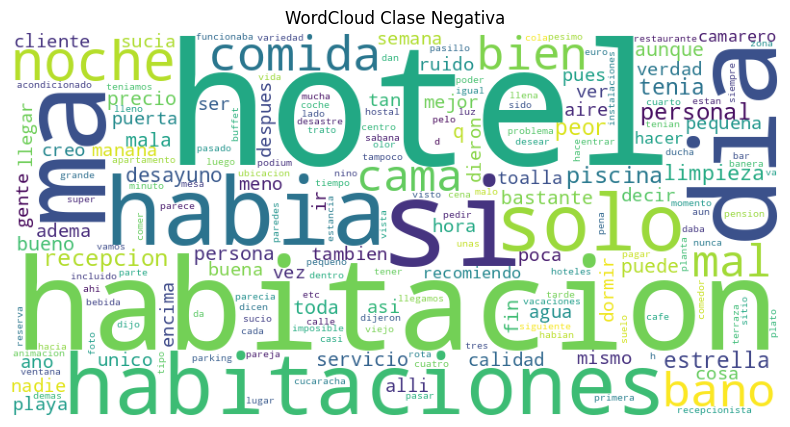

In [88]:
# WordCloud para la Clase Negativa (0)
texto_unido_n = ' '.join(df[df['rank'] == 0]['con_stop_words'].sum())
wordcloud_n = WordCloud( width=800, height=400, background_color='white', collocations=False).generate(texto_unido_n)

plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Negativa')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

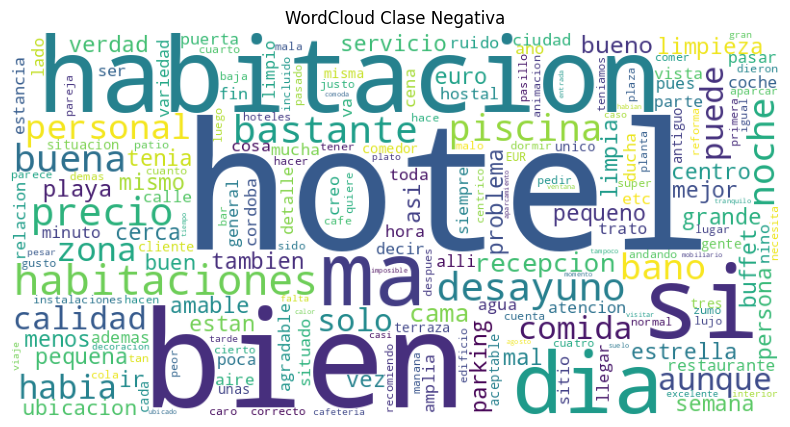

In [78]:
# WordCloud para la Clase Promedio (1)
texto_unido_n = ' '.join(df[df['rank'] == 1]['con_stop_words'].sum())
wordcloud_n = WordCloud( width=800, height=400, background_color='white', collocations=False).generate(texto_unido_n)

plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Promedio')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

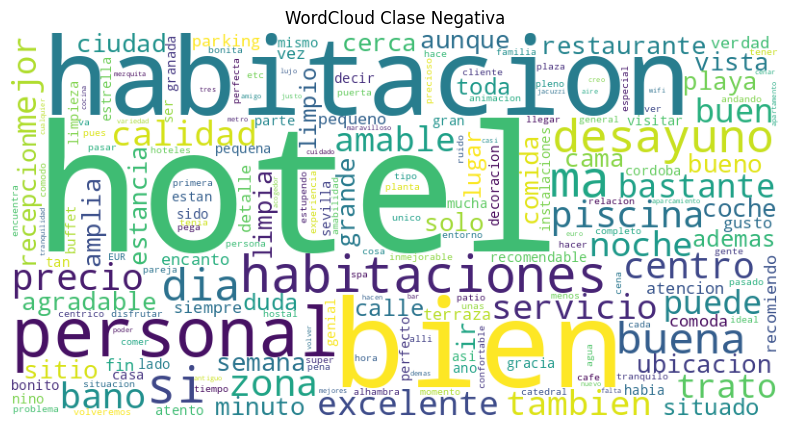

In [79]:
# WordCloud para la Clase Buena (2)
texto_unido_n = ' '.join(df[df['rank'] == 2]['con_stop_words'].sum())
wordcloud_n = WordCloud( width=800, height=400, background_color='white', collocations=False).generate(texto_unido_n)

plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Buena')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

#Biagrama

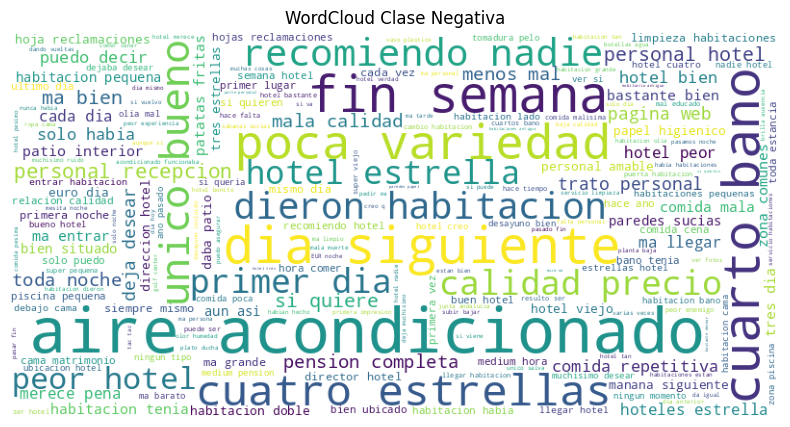

In [82]:
# Clase Negativa (0)
texto_unido_n = ' '.join(df[df['rank'] == 0]['con_stop_words'].sum())
wordcloud_n = WordCloud(width=800, height=400, background_color='white', collocation_threshold = 3).generate(texto_unido_n)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Negativa')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

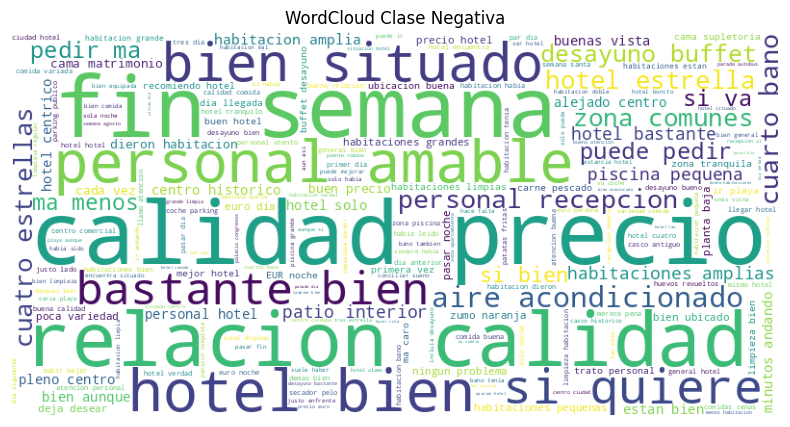

In [83]:
# Clase Promedio (1)
texto_unido_n = ' '.join(df[df['rank'] == 1]['con_stop_words'].sum())
wordcloud_n = WordCloud(width=800, height=400, background_color='white', collocation_threshold = 3).generate(texto_unido_n)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Promedio')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

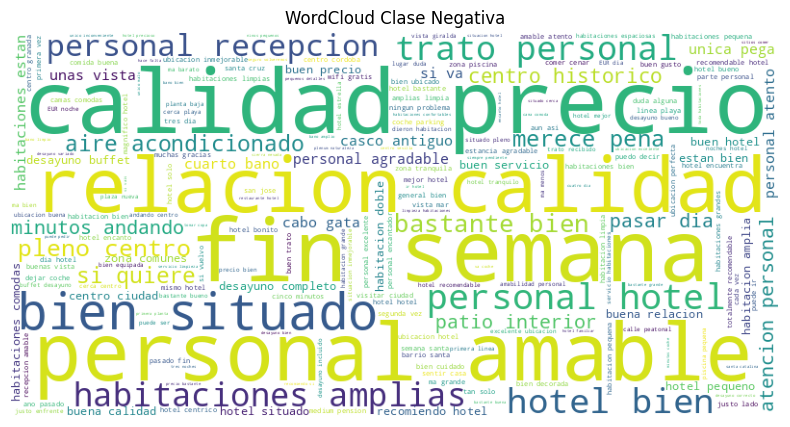

In [84]:
# Clase Buenas (2)
texto_unido_n = ' '.join(df[df['rank'] == 2]['con_stop_words'].sum())
wordcloud_n = WordCloud(width=800, height=400, background_color='white', collocation_threshold = 3).generate(texto_unido_n)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Buenas')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

# Guarda DataFrame

In [ ]:
# Guardar DataFrame como pickle
df.to_pickle('/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea1/df_procesado.pkl')

# Para cargar
# df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/df_procesado.pkl')